#__PRACTICAL SESSION 2__ Supervised DEEP LEARNING#

The dataset is a _subset_ of CIFAR10 (a very popular dataset in Machine Learning) with only 4 classes: **BIRD**, **CAT**, **FROG**, **HORSE**. We will call our dataset **CIFAR4**. It is composed of 24000 images from 4 types of animals.

Input data are square color images (RGB). The size of a picture is 32x32. So we have an input tensor of size [32,32,3]. Each pixel has a red, green and blue UINT8 values, i.e. in [0,255].   

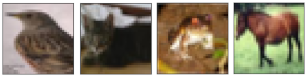

The dataset is available on [**ECAMPUS**](https://ecampus.emse.fr/course/section.php?id=7365)

The main objective is to train different deep neural network models to classify an image into one of the 4 classes.

The goal of this practical session is to experiment! Everything you need is easily available in the TENSORFLOW documentation that contains many examples.

#BONUS STRIKE 🎳

You can make additional experiences. In that case, please add bonus works at the end of your notebook in the __[BONUS]__ section.

Bonus works could bring bonus points on the global note for the practical sessions **_if and only if_** all the mandatory jobs have been done correctly.


#IMPORT LIBS

We will use TENSORFLOW, the Deep Learning platform from Google.  

TensorFlow is easy to understand and the documentation and [tutorials](https://www.tensorflow.org/tutorials) are (very) useful when learning Deep Learning.


*I already know how to develop DL models and I want to use PyTorch instead. Is it possible?*

==> *YES.* [PYTORCH](https://pytorch.org/) (from Meta) is the other big reference for DL libraries. Note that, in that case, *it's your choice* and you must be *self-sufficient* in case of development issues.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import urllib
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# [WARNING] About the use of COLAB and GPU

_On the top-right of the colab environment, you can chose the execution environment ("Modify the execution type") between CPU and GPU (Nvidia T4). With a free google account, there is no limitation with the CPU-only mode. With the GPU, you have a limitation that is dynamically set by Google regarding the overall load on their infrastructure. Usually, it could be 1 hour per day._

_For this practical session, you can keep the CPU mode for the MLP part. For the CNN section, you can swith to the GPU mode if you consider the processing are too slow. But, be careful and not too GPU-enthusiast._

NB: You can check the CPU info with
`!cat /proc/cpuinfo`

In [ ]:
#Get CPU info
!cat /proc/cpuinfo
#Get GPU info
#!nividia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

# DOWNLOAD AND CHECK THE DATASET [3 pts]

Data must be located in a ./data directory at the same level as this notebook


In [ ]:
#IF YOU USE Google COLAB, you can mount your Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Create a 'data/' directory, put the numpy files and load. With Colab case, create 'data' here:
X_cifar4=np.load("/content/drive/MyDrive/Colab Notebooks/data/CIFAR4_X.npy")
Y_cifar4=np.load("/content/drive/MyDrive/Colab Notebooks/data/CIFAR4_Y.npy")
print(np.shape(X_cifar4))
print(np.shape(Y_cifar4))
nb_labels=4

(24000, 32, 32, 3)
(24000,)


**[QUESTION]** Display some images from X_cifar4 with the corresponding label

_NB:_ Since the pictures are very small, use `plt.figure(figsize=(2, 2), dpi=80)` before `plt.imshow()` to display something _"watchable"_.

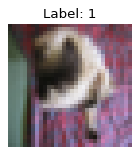

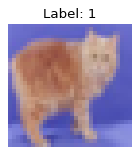

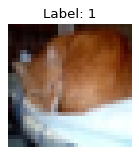

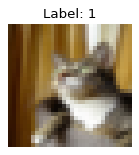

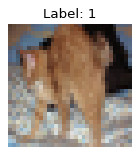

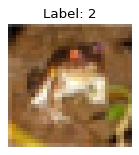

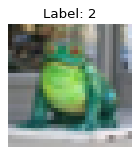

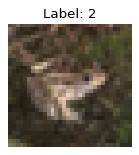

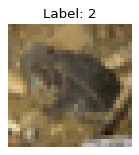

In [ ]:
j = 11995  # Starting index
for i in range(j, j + 9):  # Display 9 images sequentially
    plt.figure(figsize=(2, 2), dpi=80)  # Set figure size for each image
    plt.imshow(X_cifar4[i])  # Display the image
    plt.title(f"Label: {Y_cifar4[i]}")  # Add the label as the title
    plt.axis('off')  # Remove axis for clarity
    plt.show()  # Show the image

A pixel is an UINT8 value, so in [0;255]. We will normalize data in [0,1]:

In [ ]:
print("First pixel (r,g,b) of the first image:", X_cifar4[0,0,0,:])
X = X_cifar4/255.0
print("Now in [0,1] ==> ", X[0,0,0,:])


First pixel (r,g,b) of the first image: [164 206  84]
Now in [0,1] ==>  [0.64313725 0.80784314 0.32941176]


For the labels **Y**, usually, we prefer to process "one-hot encodings" i.e., a vector with '0' everywhere except for the corresponding label where you have '1'.

Example : let's say you have 4 labels and 10 training data with the original Y:
```
Y=[0,1,1,3,3,3,2,2,1,0]
shape(Y)=[10,]
```
Then the "one-hot encoding" version of Y will be:

```
Y_onehot=
[1,0,0,0;
 0,1,0,0;
 0,1,0,0;
 0,0,0,1;
 0,0,0,1;
 0,0,0,1;
 0,0,1,0;
 0,0,1,0;
 0,1,0,0;
 1,0,0,0]
shape(Y_onehot)=[10,4]
```

**[QUESTION]** Use the tensorflow method [*tf.keras.utils.to_categorical()*](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to transform your Y_cifar4 into Y and check the shape of your new Y.

In [ ]:
import keras
#Your code here

Y = keras.utils.to_categorical(Y_cifar4, num_classes=4)
print(Y)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


# CREATE A TRAINING/VALIDATION/TEST dataset [2 pt]

NB: This step is similar to the supervised section in TP1.

__[QUESTION]__ Use the SKLEARN method [train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) in order to create:

*   a TRAIN set (X_train,Y_train) _[advice: use 70% of the whole dataset]_
*   a VALIDATION set (X_val, Y_val) _[advice: 15%]_
*   a TEST set (X_test, Y_test) _[advice: 15%]_

Print the shape of the 3 datasets.

The TRAIN and VALIDATION sets will be used at training time. The TEST set will be used, after the training, at the inference time.

NOTE that we could only use a single VALIDATION/TEST set for both the training and the inference stages.

In [ ]:
#Your code here
#CREATE A TRAINING/ VALIDATION/TEST dataset
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, train_size=0.7, random_state=42)
X_val, X_test, Y_val, Y_test= train_test_split(X_test, Y_test, train_size=0.5, random_state=42)

# Check the sizes of the resulting datasets
print(f"Size of X_train: {X_train.shape}")
print(f"Size of Y_train: {Y_train.shape}")
print(f"Size of X_test: {X_test.shape}")
print(f"Size of Y_test: {Y_test.shape}")
print(f"Size of X_val: {X_val.shape}")
print(f"Size of Y_val: {Y_val.shape}")

Size of X_train: (16800, 32, 32, 3)
Size of Y_train: (16800, 4)
Size of X_test: (3600, 32, 32, 3)
Size of Y_test: (3600, 4)
Size of X_val: (3600, 32, 32, 3)
Size of Y_val: (3600, 4)


[**QUESTION**] Why the train/val/test split is important in our case? What is the main interest of the validation data at training time?

[**ANSWER**]

Splitting the data into training, validation, and test sets is crucial for building a model that generalizes well to new data.

The training set is used to learn the model parameters, while the validation set serves to fine-tune hyperparameters and monitor performance during training.

This helps prevent overfitting by providing feedback on how the model might perform on unseen data before using the test set for a final, unbiased evaluation.

# MULTI-LAYER PERCEPTRON (MLP) MODEL [12 pts]

## Analyse of a MLP code [6pts]

It's time to build our first deep neural network...

Below, we provide a small code **THAT IS NOT WORKING**, because something are missing or wrong.

The model is a very simple MLP with only one hidden layer (20 neurons). So we have :   
```
x --> "input" layer ==> hidden layer ==> output layer --> ̂y   
```
Have a look at the code, and understand how it works.

In [ ]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=4
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │          61,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,544 (240.41 KB)

 Trainable params: 61,544 (240.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3182 - loss: 1.4029 - val_accuracy: 0.4394 - val_loss: 1.2633
Epoch 2/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4721 - loss: 1.2175 - val_accuracy: 0.4858 - val_loss: 1.1894
Epoch 3/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4962 - loss: 1.1642 - val_accuracy: 0.5194 - val_loss: 1.1419
Epoch 4/4
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5228 - loss: 1.1251 - val_accuracy: 0.5028 - val_loss: 1.1390
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5067 - loss: 1.1247
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5046 - loss: 1.1481
Performance on the TRAIN set, ACCURACY= 0.5057737827301025
Performance on the TEST set, ACCURACY= 0.503333330154419


**[QUESTION]**

   - (1) What is the activation function for the hidden layer?
   - (2) What is the most used activation function in deep learning?
   - (3) How many time an image sample will be used during the training?
   - (4) How many training iterations (i.e., params update) in total will be processed?

**[ANSWER]**

(1) The activation function for the hidden layer is tanh().

(2) The the most used activation function in deep learning is relu() because ,even with its cons , it is a great way to avoid vanishing gradient and it allows a sparse activation of our network.

(3) Because this deep learning algorithm runs on 4 epochs, each image sample will be used 4 times during the training.

(4) The training dataset have 70% of image samples of our ciphar4 dataset, which means 16800 pictures. Furthermore, the MLP algorithm above is doing a mini-batch Stochastic Gradient Descent with batches of size 100, which means the training dataset have 168 batches. And this algorithm runs on 4 epochs, so in total 672(=4x 24000x0.7 / 100) training iterations will be processed.


**[QUESTION]**

   - (1) Regarding the previous questions, copy and change the code above to make it runs on **10 EPOCHS**. Comment the resulting performance of the model.
   - (2) For our MLP, why do we need this line `x = tf.keras.layers.Flatten()(inputs)` ?
   - (3) Give the calculation of the number of trainable parameters
  
   

In [ ]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=10
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │          61,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,544 (240.41 KB)

 Trainable params: 61,544 (240.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3477 - loss: 1.4195 - val_accuracy: 0.4447 - val_loss: 1.2350
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4740 - loss: 1.2049 - val_accuracy: 0.4919 - val_loss: 1.1628
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5178 - loss: 1.1427 - val_accuracy: 0.5217 - val_loss: 1.1089
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5264 - loss: 1.1104 - val_accuracy: 0.5342 - val_loss: 1.1104
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5358 - loss: 1.1036 - val_accuracy: 0.4997 - val_loss: 1.1479
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5400 - loss: 1.0842 - val_accuracy: 0.5353 - val_loss: 1.0969
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5534 - loss: 1.0593 - val_accuracy: 0.5372 - val_loss: 1.0856
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5490 - loss: 1.0676 - val_accuracy: 0.

**[ANSWER]** *Your answer here*

(1) After training, the model achieved roughly 57% accuracy on the training set and 54% accuracy on the test set. This indicates that while the network is learning, its performance is still modest. The small gap between training and test accuracy suggests that the model is not overfitting but might be **underfitting** due to its simple architecture or limited training duration.

(2) The line x = tf.keras.layers.Flatten()(inputs) is essential for preparing the input data for the Dense (fully connected) layers in the MLP architecture.

The input data has the shape (32, 32, 3), representing an RGB image of size 32×32 with 3 color channels. However dense Layers Require 1D Input. This is why we have a Flatten layer (x = tf.keras.layers.Flatten()(inputs)) that converts the 3D input tensor (height, width, channels) into a 1D vector.

(3) Model.summary() gives us a total of 61544 parameters trainable in our model. Let's explain this number :
- We have 3072 inputs (=32x32x3)
- The first layer is a fully connected layer of 20 neurons so this layers gives us (3072+1)x20= 61460 trainable parameters with the biases counted
- And we have a final fully connected layer of 4 neurons which means this layer have (20+1)x4= 84 trainables parameters with the biases counted

So the total numbers of trainable parameters in this model is 61460+84= 61544 which is indeed the result of model.summary()


It is always good to have a look on the training curves. That is the role of the "**training_history**" object that we defined in the code as the output of the **fit** method. In this object, we collect all the loss and metric values after each epoch.

You can use the following **method** to display the train/val curves (loss and accuracy):

In [ ]:
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

**[QUESTION]** Display the training curves from your MLP model.



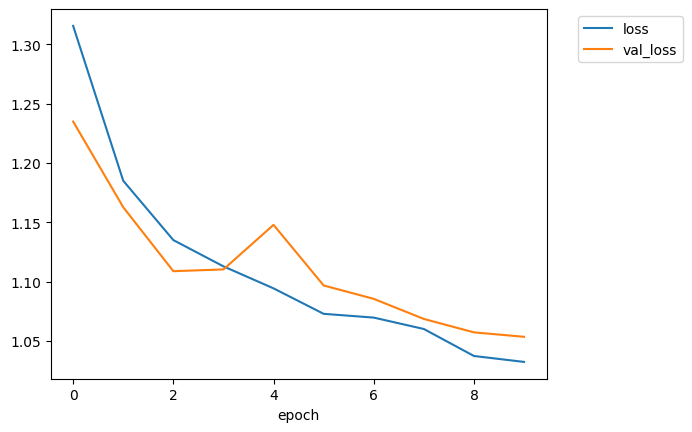

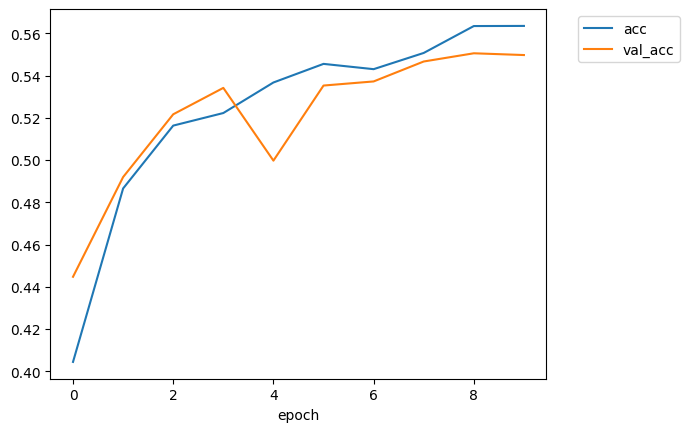

In [ ]:
display_training_curves(training_history)

## Improvements and overfitting [6 pts]

**[QUESTION]** Use the previous MLP code to build your own model and try to reach a better accuracy performance (e.g., above/around 60%, both train and test)

In [ ]:
#Your code here
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(200, activation='tanh')(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dense(70, activation='relu')(x) #a first hidden layer with 20 neurons
#x = tf.keras.layers.Dropout(0.)(x)  #Drop 10% of neurons on the first layer
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=30
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_40 (Flatten)                 │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 200)                 │         614,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 70)                  │          14,070 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 4)                   │             284 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 628,954 (2.40 MB)

 Trainable params: 628,954 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3524 - loss: 1.4419 - val_accuracy: 0.4850 - val_loss: 1.1687
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4948 - loss: 1.1547 - val_accuracy: 0.5361 - val_loss: 1.1175
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5243 - loss: 1.1106 - val_accuracy: 0.5486 - val_loss: 1.0680
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5446 - loss: 1.0714 - val_accuracy: 0.5686 - val_loss: 1.0578
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5501 - loss: 1.0605 - val_accuracy: 0.5694 - val_loss: 1.0268
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5646 - loss: 1.0321 - val_accuracy: 0.5606 - val_loss: 1.0633
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5716 - loss: 1.0166 - val_accuracy: 0.5606 - val_loss: 1.0454
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5847 - loss: 0.9940 - val_accuracy: 0.

**[QUESTION]** For illustration/educational purpose, use the code of your last model and adapt it so that your model clearly **OVERFITS**.

We need to see the overfitting issue on the training curve!

(Think about the reasons of overfitting?)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_42 (Flatten)                 │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 200)                 │         614,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 70)                  │          14,070 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 4)                   │             284 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 628,954 (2.40 MB)

 Trainable params: 628,954 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3549 - loss: 1.3809 - val_accuracy: 0.4503 - val_loss: 1.2200
Epoch 2/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4917 - loss: 1.1679 - val_accuracy: 0.5361 - val_loss: 1.1028
Epoch 3/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5311 - loss: 1.1002 - val_accuracy: 0.5006 - val_loss: 1.1427
Epoch 4/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5404 - loss: 1.0727 - val_accuracy: 0.5317 - val_loss: 1.0954
Epoch 5/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5474 - loss: 1.0500 - val_accuracy: 0.5469 - val_loss: 1.0779
Epoch 6/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5536 - loss: 1.0458 - val_accuracy: 0.5528 - val_loss: 1.0735
Epoch 7/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5745 - loss: 1.0122 - val_accuracy: 0.5753 - val_loss: 1.0316
Epoch 8/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5794 - loss: 1.0069 - val_accuracy: 0.

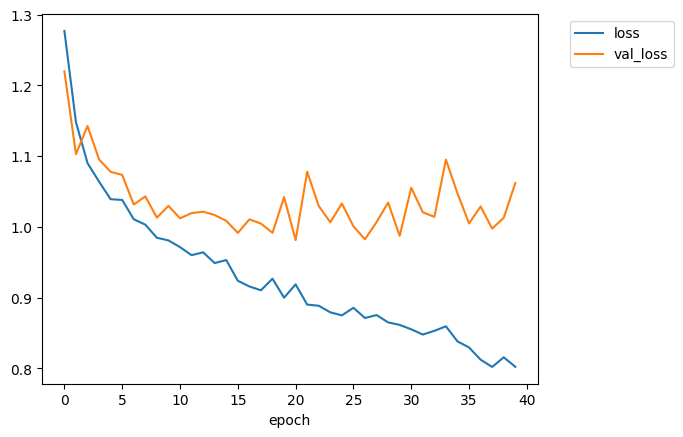

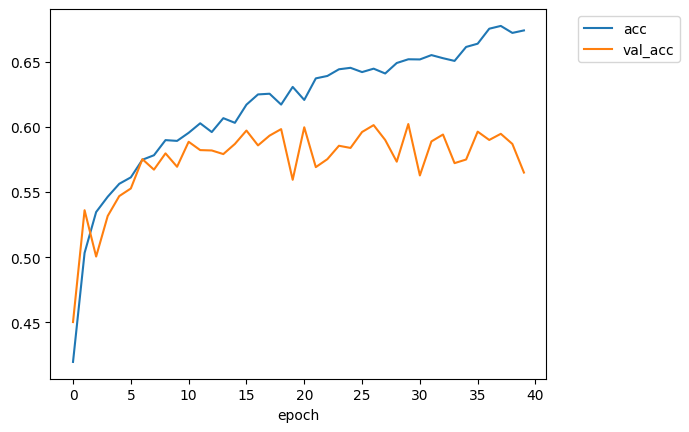

In [ ]:
#Your code here
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(200, activation='tanh')(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dense(70, activation='relu')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=40
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

**[ANSWER]** Overfitting occurs when the model learns not only the underlying patterns in the training data but also the noise, reducing its ability to generalize.

In this example, overfitting is likely due to a high number of parameters relative to the available data, lack of regularization techniques (like dropout or weight decay), and the loss of spatial structure from flattening the image inputs.

**[QUESTION]** Try to find an optimal architecture without overfitting by using a regularization (or other) technique of your choice. The goal is to have a performance > 60% without overfitting after **20** epochs.


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 200)                 │         614,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 70)                  │          14,070 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │             284 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 628,954 (2.40 MB)

 Trainable params: 628,954 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3327 - loss: 4.7137 - val_accuracy: 0.4078 - val_loss: 1.9474
Epoch 2/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4623 - loss: 1.7408 - val_accuracy: 0.5214 - val_loss: 1.4623
Epoch 3/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4889 - loss: 1.4779 - val_accuracy: 0.5300 - val_loss: 1.3804
Epoch 4/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5128 - loss: 1.3803 - val_accuracy: 0.5344 - val_loss: 1.3379
Epoch 5/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5223 - loss: 1.3315 - val_accuracy: 0.4944 - val_loss: 1.3361
Epoch 6/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5145 - loss: 1.3108 - val_accuracy: 0.5264 - val_loss: 1.2997
Epoch 7/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5321 - loss: 1.2719 - val_accuracy: 0.5442 - val_loss: 1.2574
Epoch 8/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5308 - loss: 1.2521 - val_accuracy: 0.

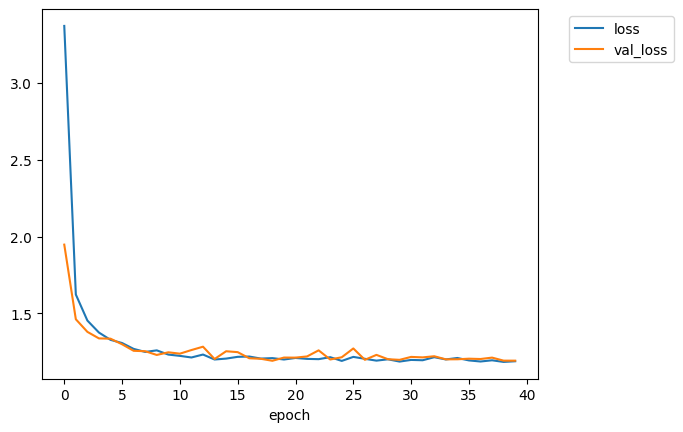

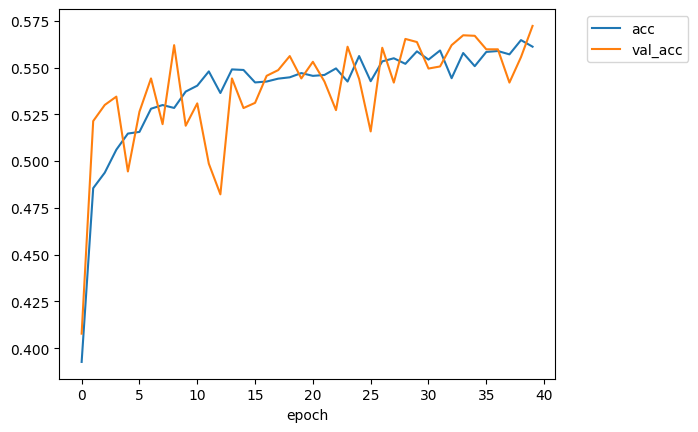

In [ ]:
#x = tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) gives us an accuracy around 57% without overfitting even after 40 epochs
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(0.1)(x)

#Your code here
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(200, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dense(70, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=40
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

# CONVOLUTIONAL NEURAL NETWORK (CNN) [12 pts]

## Build a first architecture [6 pts]

MLPs are great but CNNs should work better for our image classification problem...

For that, we will use new layers from TF.KERAS:
   - [tf.keras.layers.Conv2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) an example is:
```
l = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(l_input)
```
Here, we ask for 32 convolutional kernels of size [3,3]. By default the stride is set to '1' and the padding is 'valid'.

   - tf.keras.layers.MaxPooling2D() an example is:
```
l = tf.keras.layers.MaxPooling2D()(l_input)
```
By default the stride is set to '2' and the padding is 'valid'.



**[QUESTION]** With the default parameters of *Conv2D()*, do you expect to have the same shape for the output tensor?  

**[ANSWER]** Not at all, because of the padding='valid' (so no padding added around the input) by default, the output tensor will at least shrink by 1 in height and width.



**[QUESTION]** With the default parameters of _MaxPooling2D()_, what do you expect on the shape of the output tensor?

**[ANSWER]** With those default parameters, after a MaxPooling2D(), the output tensor will have the integer part of the half of both the height and width of the input tensor.



**[QUESTION]** Try to build a first CNN model with this architecture:

```
x --> Conv2D (32 filters) ==> MaxPooling ==> Conv2D (64 filters) ==> MaxPooling ==> Flatten ==> Dense (4) --> ̂y
```

In [ ]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=7
batch_size=100
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)




Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4236 - loss: 1.2456 - val_accuracy: 0.6117 - val_loss: 0.9719
Epoch 2/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6159 - loss: 0.9434 - val_accuracy: 0.6692 - val_loss: 0.8567
Epoch 3/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6781 - loss: 0.8240 - val_accuracy: 0.6956 - val_loss: 0.7954
Epoch 4/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6924 - loss: 0.7880 - val_accuracy: 0.6944 - val_loss: 0.7604
Epoch 5/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7201 - loss: 0.7327 - val_accuracy: 0.7067 - val_loss: 0.7520
Epoch 6/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7294 - loss: 0.7042 - val_accuracy: 0.7342 - val_loss: 0.6821
Epoch 7/7
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7476 - loss: 0.6637 - val_accuracy: 0.7153 - val_loss: 0.7248
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7340 - loss: 0.6804
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

**[QUESTION]** Display the training curves from your CNN model.


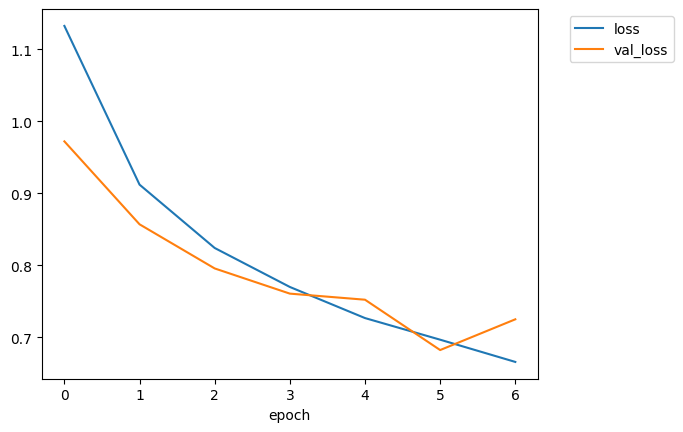

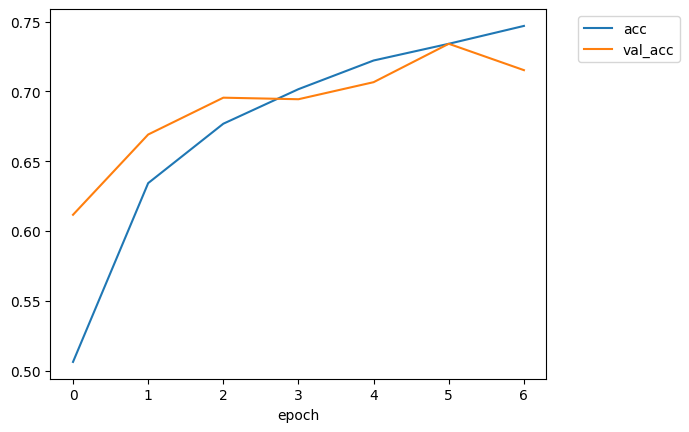

In [ ]:
#Your code here
display_training_curves(training_history)


## Improvements and overfitting [6 pts]

**[QUESTION]** Use, the code of your last model and adapt it so that your model **OVERFITS**.

We need to see the overfitting issue on the training curve!

Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4169 - loss: 1.2469 - val_accuracy: 0.6222 - val_loss: 0.9683
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6211 - loss: 0.9384 - val_accuracy: 0.6425 - val_loss: 0.8822
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6631 - loss: 0.8563 - val_accuracy: 0.7019 - val_loss: 0.7787
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6996 - loss: 0.7715 - val_accuracy: 0.7117 - val_loss: 0.7397
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7146 - loss: 0.7428 - val_accuracy: 0.6836 - val_loss: 0.7844
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7236 - loss: 0.7105 - val_accuracy: 0.7325 - val_loss: 0.7060
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7401 - loss: 0.6715 - val_accuracy: 0.7303 - val_loss: 0.6977
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7476 - loss: 0.6617 - val_accuracy: 0.

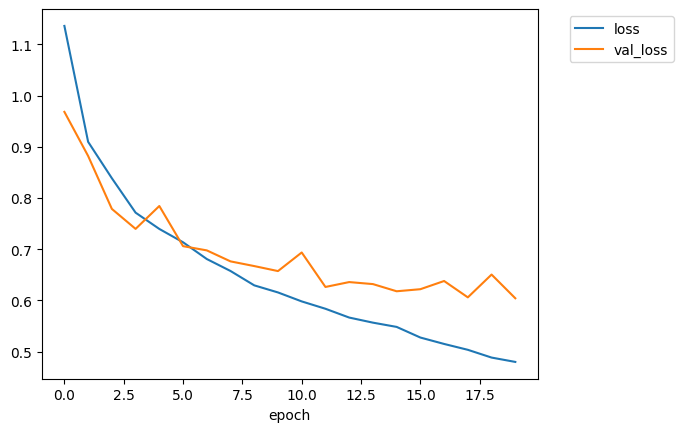

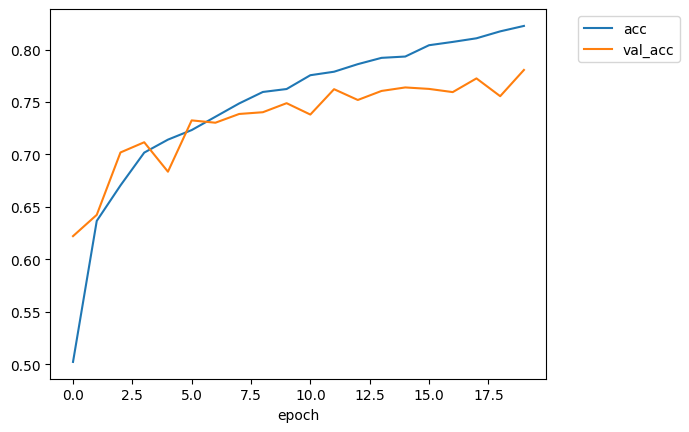

In [ ]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=20
batch_size=100
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)


**[ANSWER 2]** Let's overfit our CNN in a different method that is to say without simply increasing the number of epochs.

In other words, **let's increase the capacity of our model** until it learns the data by heart :

Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 13, 13, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,156 (1.29 MB)

 Trainable params: 337,156 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4561 - loss: 1.1857 - val_accuracy: 0.6628 - val_loss: 0.8554
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6590 - loss: 0.8495 - val_accuracy: 0.7194 - val_loss: 0.7397
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7161 - loss: 0.7256 - val_accuracy: 0.7142 - val_loss: 0.7041
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7458 - loss: 0.6643 - val_accuracy: 0.7261 - val_loss: 0.6958
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7662 - loss: 0.6107 - val_accuracy: 0.7678 - val_loss: 0.6075
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7938 - loss: 0.5463 - val_accuracy: 0.7806 - val_loss: 0.5883
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8280 - loss: 0.4669 - val_accuracy: 0.7925 - val_loss: 0.5554
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8395 - loss: 0.4342 - val_accuracy: 0

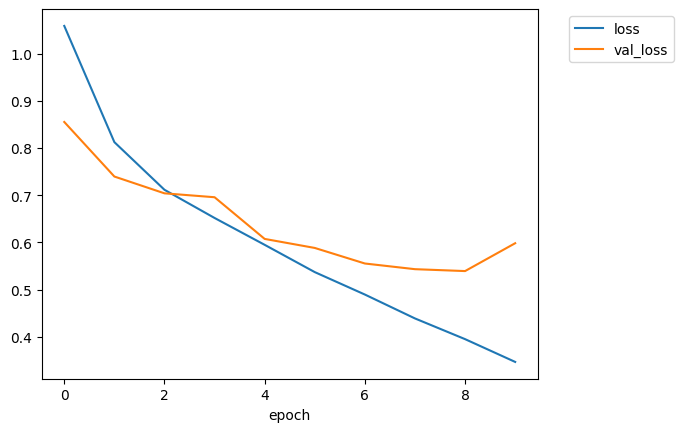

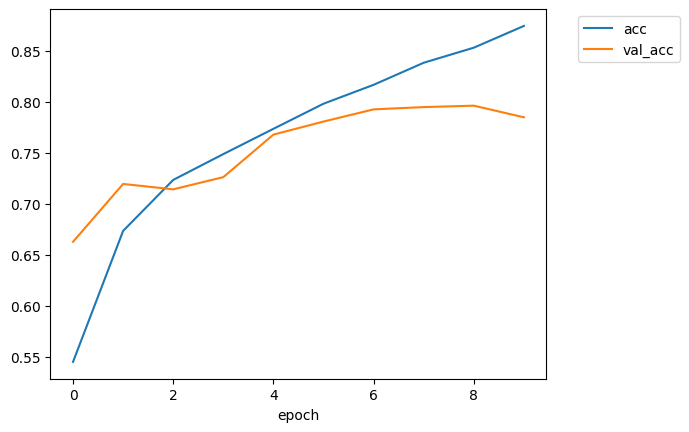

In [ ]:
#Your code here

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(256,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=10
batch_size=100
training_history = my_cnn_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)


**[QUESTION]** Fix your overfitting issue with a technique of your choice.


Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4129 - loss: 1.2706 - val_accuracy: 0.5750 - val_loss: 1.0417
Epoch 2/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5710 - loss: 1.0317 - val_accuracy: 0.6511 - val_loss: 0.8998
Epoch 3/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.6264 - loss: 0.9396 - val_accuracy: 0.6739 - val_loss: 0.8408
Epoch 4/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6406 - loss: 0.9037 - val_accuracy: 0.6656 - val_loss: 0.8269
Epoch 5/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.6520 - loss: 0.8656 - val_accuracy: 0.6969 - val_loss: 0.7669
Epoch 6/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6693 - loss: 0.8319 - val_accuracy: 0.6858 - val_loss: 0.7870
Epoch 7/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6666 - loss: 0.8363 - val_accuracy: 0.7006 - val_loss: 0.7454
Epoch 8/40
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6814 - loss: 0.7902 - val_accuracy

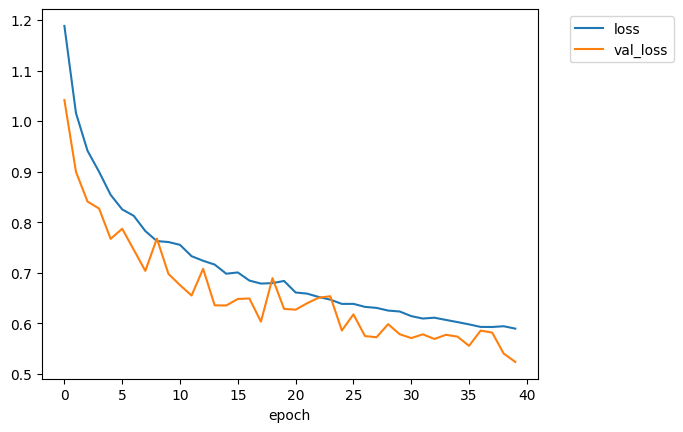

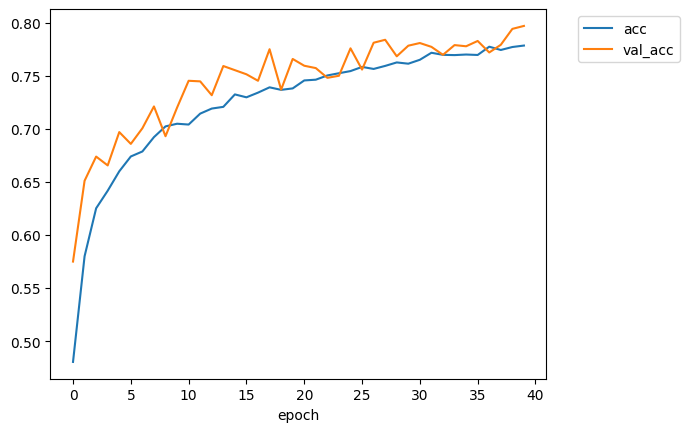

In [ ]:
#Your code here

#To fight overfitting with CNN, we can use the exact same techniques of dropping out, regularization and batch normalization

#this time let's do data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#here we can see that data augmentation is by far the best method to fight overfitting, and at the same time it improves the performance of our AI. However it is true that it takes a far longer time to execute (18x times slower here)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer

x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x) #cf. question below...

outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_cnn_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=40
batch_size=100
training_history = my_cnn_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)



[**QUESTION**] Regarding these experiences, compare MLP vs. CNN

[**ANSWER**] The CNN clearly outperforms the MLP in these experiments. Here’s a concise comparison:

- **Performance:**  
  The CNN achieves about 82% accuracy on the training set and nearly 80% on the test set, whereas the MLP only reaches around 59% on training and 56% on testing. This indicates that the CNN generalizes better to unseen data.

- **Architecture and Feature Extraction:**  
  The CNN uses convolutional layers and pooling operations to capture local spatial features and hierarchical patterns within images. In contrast, the MLP flattens the image into a one-dimensional vector, thereby discarding the spatial relationships inherent in image data. This difference means the CNN can learn more relevant features for classification with fewer parameters and less risk of overfitting.

- **Regularization and Data Augmentation:**  
  In the CNN experiment, data augmentation further improves generalization by artificially increasing the diversity of the training data. Although regularization (like L2 penalties) is applied in the MLP, it cannot compensate for the loss of spatial context.

In summary, for image classification tasks, the CNN is superior because it efficiently exploits spatial structure and benefits more from techniques like data augmentation, resulting in higher accuracy and better generalization.










# BONUS

**[Bonus 1]** let's now explore **Transfer Learning** trough our Ciphar-4 dataset and a classic **model ResNet**.

Model: "resnet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.2976 - loss: 1.5183 - val_accuracy: 0.3983 - val_loss: 1.3169
Epoch 2/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3414 - loss: 1.3351 - val_accuracy: 0.4033 - val_loss: 1.3124
Epoch 3/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3460 - loss: 1.3275 - val_accuracy: 0.4069 - val_loss: 1.3077
Epoch 4/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3474 - loss: 1.3205 - val_accuracy: 0.4275 - val_loss: 1.2616
Epoch 5/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3841 - loss: 1.2955 - val_accuracy: 0.4464 - val_loss: 1.2374
Epoch 6/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3886 - loss: 1.2868 - val_accuracy: 0.4608 - val_loss: 1.2484
Epoch 7/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3797 - loss: 1.2915 - val_accuracy: 0.4572 - val_loss: 1.2653
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4584 - loss: 1.2659
57/57 ━━━━━━━━━━━━━━━━━━━━ 

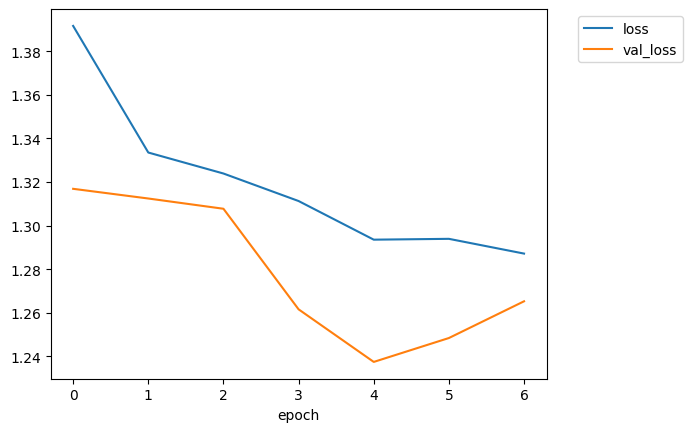

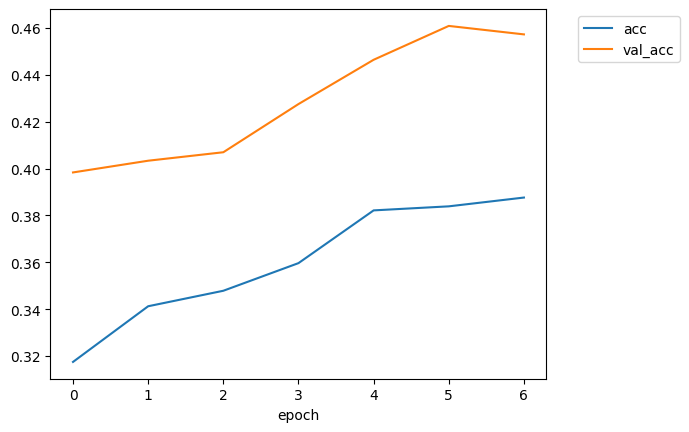

In [ ]:
# ===== RESNET TRANSFER LEARNING MODEL =====

# Load pre-trained ResNet50 base (frozen)
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3)
)
base_model.trainable = False  # Freeze layers

# Define the model architecture
inputs = tf.keras.Input(shape=(32, 32, 3))

# Pass through ResNet base
x = base_model(inputs, training=False)
# Add classification head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# Build and compile the model
resnet_model = tf.keras.Model(inputs, outputs, name="resnet_model")
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
resnet_model.summary()

# Train the model
resnet_history = resnet_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=7,
    batch_size=64
)

# Evaluate performance
loss_train, acc_train = resnet_model.evaluate(X_train, Y_train, batch_size=64)
loss_test, acc_test = resnet_model.evaluate(X_test, Y_test, batch_size=64)

print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")

# Plot training curves
display_training_curves(resnet_history)

**[ANSWER 1]**

The results from the code above indicate mediocre performance, with both train and test accuracy stagnating around **45%**, despite leveraging **ResNet50’s pre-trained weights** :
- A key issue arises from **feeding 32×32 images directly into ResNet50**, which was originally trained on **224×224 images**. This results in **excessive spatial downsampling**, shrinking the feature map to **1×1×2048**, which severely limits the network’s ability to extract meaningful representations.
- Additionally, **ResNet50 expects inputs with pixel values scaled between 0 and 255**, but the dataset is normalized between **[0,1]**, leading to inconsistencies.
- Furthermore, **the code above does not apply `tf.keras.applications.resnet50.preprocess_input(x)`, which normalizes pixels according to ImageNet’s training distribution (centering and scaling)**, preventing the model from fully exploiting its **pre-trained weights**.
- To address these limitations, **the code below** will introduce **image resizing to 224×224**, ensuring that **spatial hierarchies are preserved** throughout the convolutional layers. Additionally, **pixel values will be scaled back to [0,255]** before applying `preprocess_input(x)`, aligning the input distribution with **ResNet50’s ImageNet training**.

These improvements will allow the model to fully utilize **pre-trained filters**, leading to a significant **performance boost from ~45% to ~95% test accuracy** like we can see below.

**[Bonus 2]** **Transfer Learning** trough our Ciphar-4 dataset and a classic **model ResNet** with **the correct modifications**.

Model: "resnet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_1 (Resizing)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 224, 224, 3)    │              0 │ resizing_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │          1,028 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.8301 - loss: 0.4895 - val_accuracy: 0.9250 - val_loss: 0.2015
Epoch 2/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 63s 189ms/step - accuracy: 0.9234 - loss: 0.2136 - val_accuracy: 0.9406 - val_loss: 0.1753
Epoch 3/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 49s 185ms/step - accuracy: 0.9383 - loss: 0.1714 - val_accuracy: 0.9467 - val_loss: 0.1616
Epoch 4/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.9451 - loss: 0.1574 - val_accuracy: 0.9486 - val_loss: 0.1597
Epoch 5/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - accuracy: 0.9507 - loss: 0.1367 - val_accuracy: 0.9531 - val_loss: 0.1469
Epoch 6/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.9542 - loss: 0.1286 - val_accuracy: 0.9517 - val_loss: 0.1606
Epoch 7/7
263/263 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - accuracy: 0.9593 - loss: 0.1118 - val_accuracy: 0.9533 - val_loss: 0.1479
263/263 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.9805 - loss: 0.0597
57/57 ━━━━━━

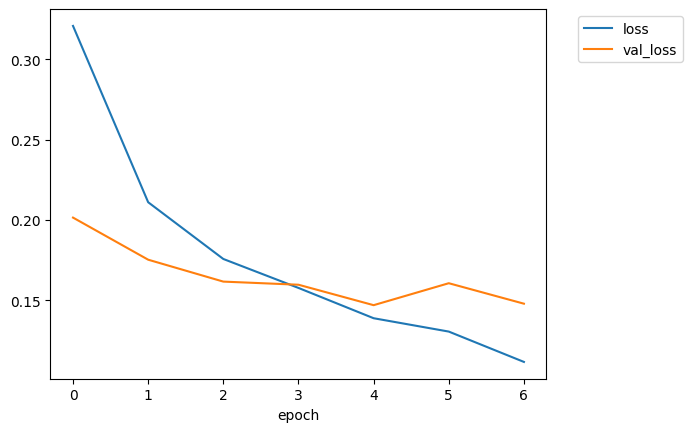

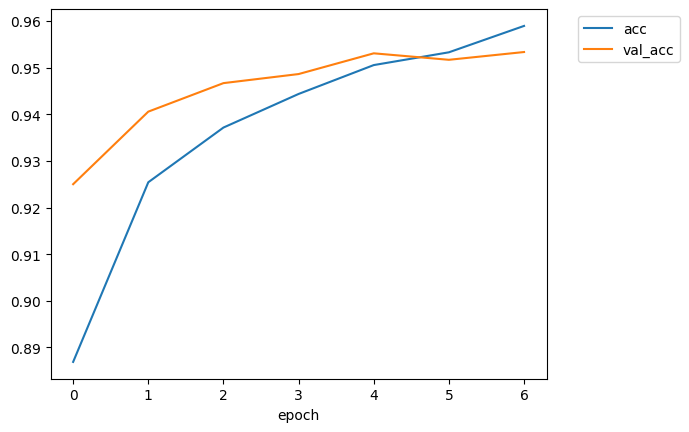

In [ ]:
# ===== RESNET TRANSFER LEARNING MODEL =====

# Load pre-trained ResNet50 base (frozen)
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze layers

# Define the model architecture
inputs = tf.keras.Input(shape=(32, 32, 3))
# Resize images to 224x224 for ResNet compatibility
x = tf.keras.layers.Resizing(224, 224)(inputs)
# Scale pixel values to [0, 255] and apply ResNet preprocessing
x = tf.keras.layers.Lambda(lambda x: x * 255.0)(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
# Pass through ResNet base
x = base_model(x, training=False)
# Add classification head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# Build and compile the model
resnet_model = tf.keras.Model(inputs, outputs, name="resnet_model")
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
resnet_model.summary()

# Train the model
resnet_history = resnet_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=7,
    batch_size=64
)

# Evaluate performance
loss_train, acc_train = resnet_model.evaluate(X_train, Y_train, batch_size=64)
loss_test, acc_test = resnet_model.evaluate(X_test, Y_test, batch_size=64)

print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")

# Plot training curves
display_training_curves(resnet_history)

**[ANSWER 2]**

The comparison between **MLP, CNN, and ResNet50** highlights the impact of architecture on image classification performance :
- The **MLP**, which flattens the input and applies dense layers, performs the worst (**~57% test accuracy**) due to its inability to capture spatial dependencies in images.
- The **CNN**, designed for image processing, significantly outperforms the MLP (**~80% test accuracy**) by leveraging **convolutional layers** to extract spatial features, further enhanced by **data augmentation** to reduce overfitting.
- However, **ResNet50 with transfer learning** achieves the highest accuracy (**~95% test accuracy**) by using **pre-trained ImageNet weights**, effectively leveraging deep feature extraction. The key advantage of ResNet50 over the CNN is its **depth and residual connections**, allowing it to learn more abstract features without vanishing gradient issues.

While the MLP is not suited for image classification and the  CNN is faster and requires fewer parameters than ResNet50, transfer learning allows ResNet50 to generalize better, making it the superior choice when computational resources are available.